# Imports

In [1]:
#use spacy instead
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import random

In [65]:
import re
import string
#from tqdm import tqdm

In [16]:
# for wordclouds and regular expressions
from wordcloud import WordCloud

look for specific tweet by id:type
"https://twitter.com/statuses/" + id_str

first day of scraping (as first day of investigation): 18.10.2018, (am 06.11. wurden Organisationen inkludiert)

## Functions

In [6]:
def get_date(x):
    """
    returns only the date of a datetime object
    """
    return x.date()

In [7]:
def restrict_time(df,date):
    """
    function to restrict the df to shorter time span by specifying the beginning date
    """
    split_date=date.split(".")
    for i in range(len(split_date)):
        if int(split_date[i])<9:
            split_date[i]=split_date[i][1]
    return df[df["time"].dt.date>dt.datetime(int(split_date[2]), int(split_date[1]), int(split_date[0]), 0, 0).date()]

In [8]:
def reshape_daily(df):
    """
    reshapes and aggregates df to daily interval
    """
    df["date"]=df["time"].apply(get_date)
    df=df.groupby("date").count()
    df["Tweets/Tag"]=df["time"]
    alle_variablen=list(df)
    alle_variablen.remove("Tweets/Tag")
    [df.drop(x,axis=1,inplace=True) for x in alle_variablen];
    return df

In [6]:
# extract the receiver of messages, indicated by @ mentions
import re
def extract_receiver(text):
    """
    extracts the persons with '@'mentions in tweets
    """
    hashtag_list = re.findall(r"@(\w+)", text)
    output=", ".join(hashtag_list)
    return output

In [7]:
import re
def extract_hashtag(text):
    """
    extracts strings following '#' signs in tweets
    """
    hashtag_list = re.findall(r"#(\w+)", text)
    output=", ".join(hashtag_list)
    return output

## Data preparation

In [5]:
tweets_complete=pd.read_csv("tweets_all.csv",delimiter=";", index_col="id") #dtype={'user_id': int} dtypes aller reihen 
tweets_complete.shape

(214294, 17)

In [10]:
tweets_complete["time"]=pd.to_datetime(tweets_complete["time"])

In [4]:
tweets_complete.head();

In [12]:
random_nr=random.choice(range(len(tweets_complete)))
print(random_nr,": ",tweets_complete["text"].iloc[random_nr])

89924 :  Comienza la rueda de prensa de sociedad civil y representantes políticos en apoyo al proceso de Naciones Unidas hacia un instrumento vinculante para acabar con la impunidad de empresas trasnacionales que cometen violaciones de DDHH.

🔴 Directo en fb: https://t.co/9e1nVwbhvj https://t.co/uwnLom2ZBZ


### restrict to tweets after certain Date only  - e.g. 17.10.2018 

In [11]:
tweets_Nov=restrict_time(tweets_complete,"01.11.2018")

In [12]:
len(tweets_Nov)

130916

In [13]:
tweets_Nov["time"].min()

Timestamp('2018-11-02 00:01:30')

### Aggregate overall tweets per day

In [14]:
Nov_daily=reshape_daily(tweets_Nov);
Nov_daily.shape

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(68, 1)

In [15]:
Nov_daily.describe()

,Tweets/Tag
count,68.000000
mean,1925.235294
std,803.762591
min,232.000000
25%,1278.250000
50%,1857.500000
75%,2588.750000
max,3867.000000


# Analyse

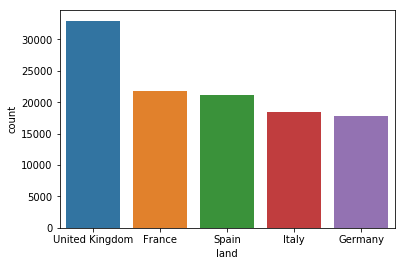

In [24]:
sns.countplot(tweets_complete["land"],order=tweets_complete["land"].value_counts().index[:5])

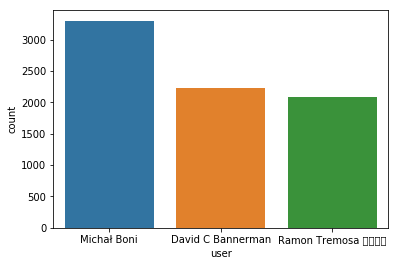

In [26]:
sns.countplot(tweets_complete["user"],order=tweets_complete["user"].value_counts().index[:3])

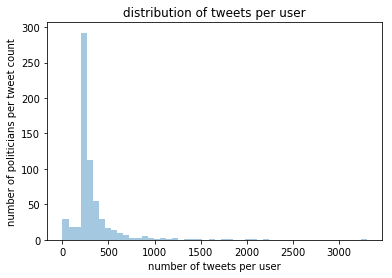

In [31]:
ax=sns.distplot(tweets_complete["user"].value_counts(),kde=False)
ax.set(xlabel='number of tweets per user',ylabel='number of politicians per tweet count', title='distribution of tweets per user')
plt.show()

In [32]:
tweets_complete["user"].value_counts().tail(20)

Karol Karski                    28
Meszerics Tamas                 26
Uspaskich                       23
Beata Gosiewska                 16
Jan Keller                      15
Răzvan Popa                     11
Krystyna Łybacka                10
Janusz Zemke                     9
Annie Schreijer-Pierik (CDA)     9
Adam Gierek                      8
Boris Zala                       8
Algirdas Saudargas               7
Bocskor Andrea                   6
Claude Moraes                    3
kristina winberg                 3
Liisa Jaakonsaari                3
dr Andrzej Grzyb                 3
Bronis Ropė                      2
JeromeLavrilleux                 1
Karin Kadenbach                  1
Name: user, dtype: int64

91 user mit mindestens einem Tweet (bzw. 8 Min.) im beobachteten Zeitraum (bis 02.11.18)

## Auswertung der Tweets pro Tag - Trends, Auffälligkeiten

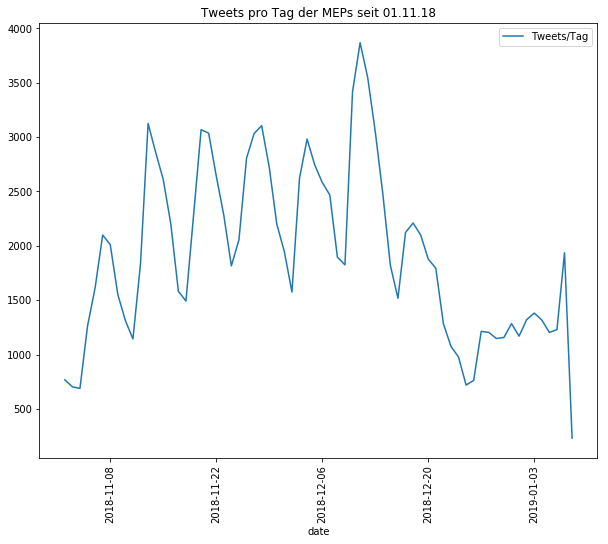

In [16]:
Nov_daily.plot(figsize=(10,8),title="Tweets pro Tag der MEPs seit 01.11.18",rot=90)

In [37]:
tweet_peak=Nov_daily[Nov_daily["Tweets/Tag"]==Nov_daily["Tweets/Tag"].max()].index.values
Nov_daily[Nov_daily["Tweets/Tag"]==Nov_daily["Tweets/Tag"].max()]

,Tweets/Tag
date,
2018-12-11,3860


In [53]:
Nov_daily[Nov_daily["Tweets/Tag"]==Nov_daily["Tweets/Tag"].max()].index.values[0].year

2018

In [59]:
max_tweet=Nov_daily[Nov_daily["Tweets/Tag"]==Nov_daily["Tweets/Tag"].max()]["Tweets/Tag"]
print("Maximale Tweets per Tag:")
print("{} Tweets am {}.{}.{}".format(max_tweet.values[0],max_tweet.index.values[0].day,max_tweet.index.values[0].month,max_tweet.index.values[0].year))

Maximale Tweets per Tag:
3860 Tweets am 11.12.2018


In [60]:
max_tweet_date=Nov_daily[Nov_daily["Tweets/Tag"]==Nov_daily["Tweets/Tag"].max()]["Tweets/Tag"].index.values[0]
tweets_peak=tweets_complete[tweets_complete["time"].dt.date==dt.datetime(max_tweet_date.year, max_tweet_date.month, max_tweet_date.day, 0, 0).date()]

In [62]:
tweets_peak["text"].iloc[10]

'En la firma hoy en el #ParlamentoEuropeo del Nuevo Reglamento de #PiensosMedicamentosos con el Presidente @EP_President y @CzSiekierski @Socialistas_PE @V_Andriukaitis https://t.co/GWll0xZQJm'

In [66]:
tweets_peak["receiver"]=tweets_peak["text"].apply(extract_receiver)

C:\Users\David\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
all_receiver=list(tweets_peak["receiver"])
all_receiver=[x for x in all_receiver if x != '']

In [ ]:
wordcloud_receiver = WordCloud(width=800, height=600, margin=0,background_color="white",relative_scaling=0.5).generate(' '.join(all_receiver))

In [ ]:
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_receiver, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
#plt.savefig("Nachrichten_empfänger.png")
plt.show()

In [197]:
wordcloud_user = WordCloud(width=800, height=600, margin=0,background_color="white",relative_scaling=0.5).generate(' '.join(list(tweets181018["user"].values)))

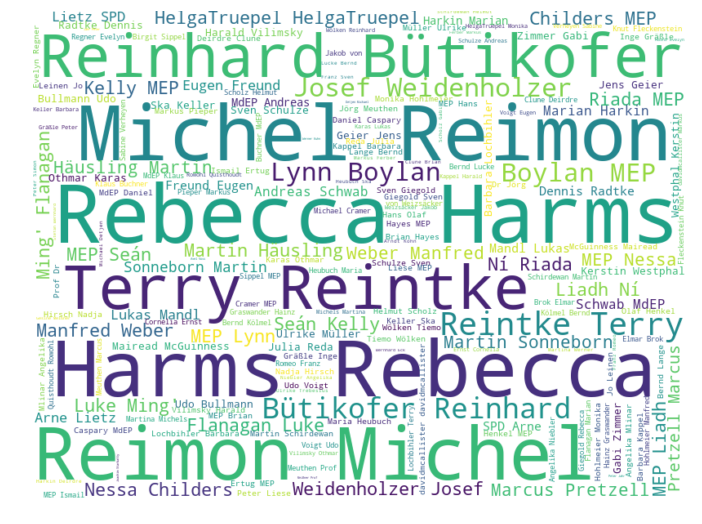

In [198]:
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_user, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
#plt.savefig("Nachrichten_empfänger.png")
plt.show()

#aggregate Terry Reintke and Reintke Terry

In [ ]:
tweets_complete["hashtags_extracted"]=tweets_complete["text"].apply(extract_hashtag)

In [ ]:
tweets_peak["hashtags_extracted"]=tweets_peak["text"].apply(extract_hashtag)

In [50]:
wordcloud_hashtags = WordCloud(width=800, height=600, margin=0,background_color="white",relative_scaling=0.5).generate(' '.join(tweets_peak["hashtags_extracted"].values))

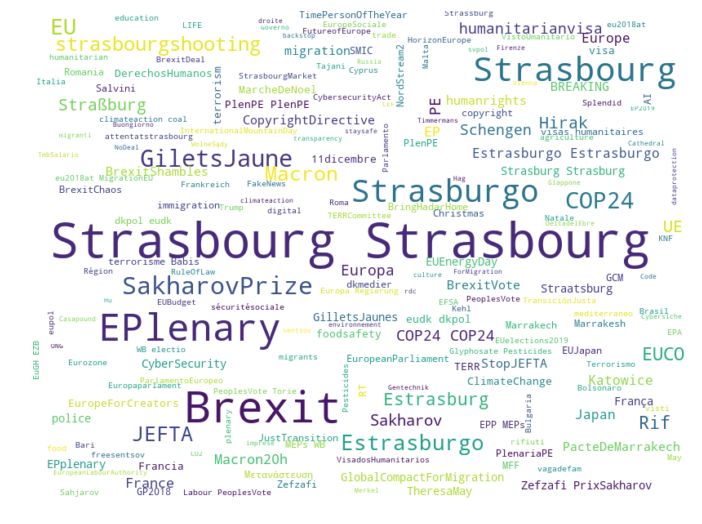

In [51]:
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_hashtags, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
#plt.savefig("Nachrichten_empfänger.png")
plt.show()

# Trending Hashtags

In [7]:
hashs=pd.read_csv("trending_hashtags.csv",delimiter=";")

In [8]:
hashs["uhrzeit_scrape"]=pd.to_datetime(hashs["uhrzeit_scrape"])

In [9]:
hashs["uhrzeit_scrape"].values[0]

numpy.datetime64('2018-11-03T21:34:41.169684000')

In [10]:
hashs.shape

(34429, 3)

In [11]:
hashs.head()

,ort,uhrzeit_scrape,hashtag
0,Deutschland,2018-11-03 21:34:41.169684,#FCBSCF
1,Deutschland,2018-11-03 21:34:41.169684,#BSCRBL
2,Deutschland,2018-11-03 21:34:41.169684,#ARSLIV
3,Deutschland,2018-11-03 21:34:41.169684,#Supertalent
4,Deutschland,2018-11-03 21:34:41.169684,#Wilsberg


In [12]:
hashs.tail()

,ort,uhrzeit_scrape,hashtag
34424,UK,2018-12-28 22:26:03.291574,#VinylRevival
34425,UK,2018-12-28 22:26:03.291574,#MakeAFilmDismal
34426,UK,2018-12-28 22:26:03.291574,#blackcountrymovies
34427,UK,2018-12-28 22:26:03.291574,#FiK57
34428,UK,2018-12-28 22:26:03.291574,#Casualty


In [13]:
hashs["hashtag"].values

array(['#FCBSCF', '#BSCRBL', '#ARSLIV', ..., '#blackcountrymovies',
       '#FiK57', '#Casualty'], dtype=object)

In [17]:
wordcloud_trending_hashtags = WordCloud(width=800, height=600, margin=0,background_color="white",relative_scaling=0.5).generate(' '.join(hashs["hashtag"].values))

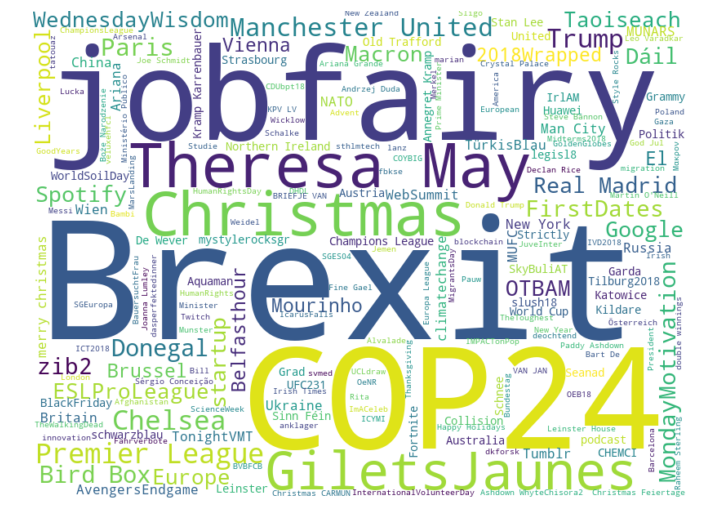

In [18]:
plt.figure(figsize=(16,9))
plt.imshow(wordcloud_trending_hashtags, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
#plt.savefig("Nachrichten_empfänger.png")
plt.show()